In [12]:
from kdg import kdf
from kdg.utils import sparse_parity, get_ece, plot_2dsim
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from joblib import Parallel, delayed
from scipy.io import savemat, loadmat
from sklearn.metrics import roc_auc_score
import numpy as np

In [8]:
X, y = sparse_parity(10000, p_star=2,p=2)
X_test, y_test = sparse_parity(1000, p_star=2,p=2)

<AxesSubplot: >

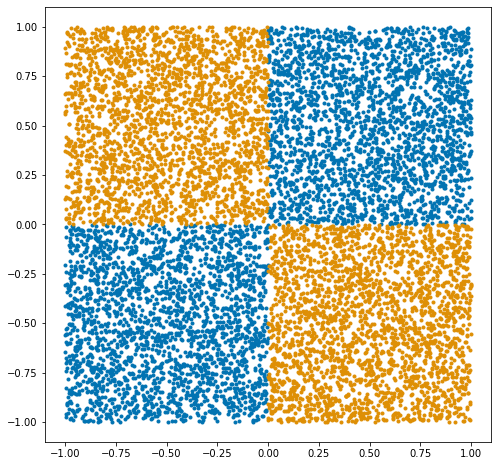

In [9]:
plot_2dsim(X, y)

In [10]:
model_kdf = kdf(k=1e5, kwargs={'n_estimators':500})
model_kdf.fit(X, y)


In [13]:
proba_kdf = model_kdf.predict_proba(X_test)
proba_rf = model_kdf.rf_model.predict_proba(X_test)
predicted_label_kdf = np.argmax(proba_kdf, axis = 1)
predicted_label_rf = np.argmax(proba_rf, axis = 1)

In [14]:
get_ece(proba_kdf, predicted_label_kdf, y_test)

0.028783796203402354

In [15]:
get_ece(proba_rf, predicted_label_rf, y_test)

0.03904399999999998

In [81]:
def plot_reliability(proba, predicted_label, true_label, R=15):
    K = proba.shape[1]
    fig1, ax = plt.subplots(1, K, figsize=(8*K, 8))
    sns.set_context('talk')
    
    for k in range(K):
        posteriors = proba[:,k]
        sorted_indx = np.argsort(posteriors)
        bin_size = len(sorted_indx)//R
        
        ax[k].hlines(0, 0, R, linewidth=1)
        for r in range(R):
            indx = sorted_indx[r*bin_size:(r+1)*bin_size]
            predicted_label_ = predicted_label[indx]
            true_label_ = true_label[indx]
            indx_k = np.where(true_label_ == k)[0]
            acc = (
                np.nan_to_num(np.mean(predicted_label_[indx_k] == k))
                if indx_k.size != 0
                else 0
            )
            
            conf = np.nan_to_num(np.mean(posteriors[indx])) if indx.size != 0 else 0
            #print(sorted_indx)
            x1 = posteriors[indx[0]]
            x2 = posteriors[indx[-1]]
            ax[k].hlines(acc, r, r+1, linewidth=3)
            ax[k].hlines(conf, r, r+1, linewidth=3, color='r')
            
            if acc>conf:
                ax[k].fill_between([r,r+1], conf, acc, facecolor='r', alpha=.3)
            else:
                ax[k].fill_between([r,r+1], acc, conf, facecolor='r', alpha=.3)
                
            
            ax[k].vlines(r, 0, acc, linewidth=1)
            ax[k].set_xticks(np.arange(16))
            ax[k].set_xlabel('Bin number')
            ax[k].set_ylabel('Accuracy(blue) or Confidence(red)')
            ax[k].set_title('Label '+str(k))
        ax[k].vlines(R, 0, acc, linewidth=1)

# Plot Reliability Diagram for KDF

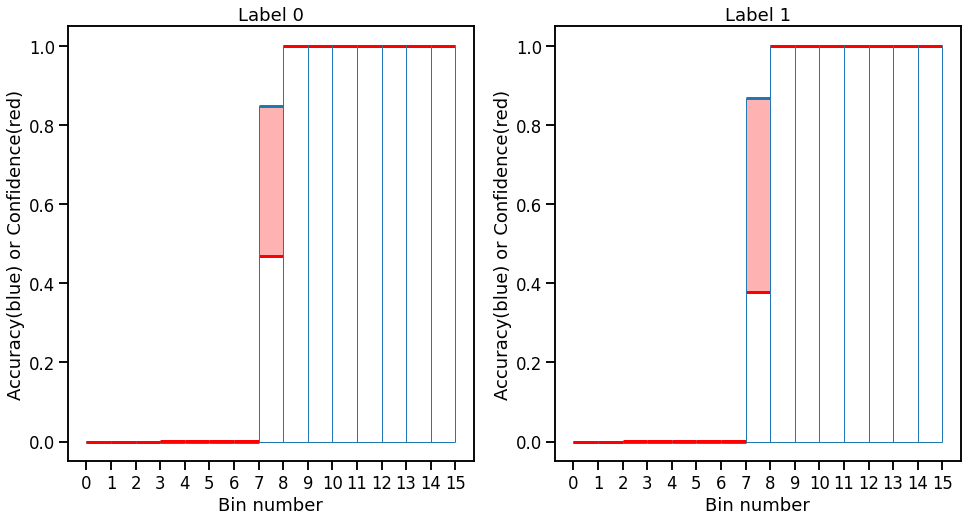

In [82]:
plot_reliability(proba_kdf, predicted_label_kdf, y_test)

# Plot Reliability Diagram for Random Forest

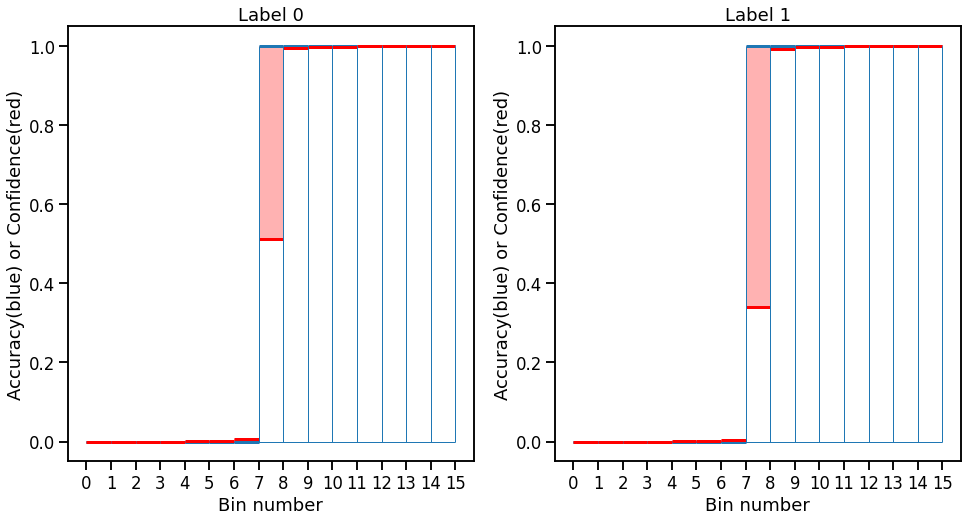

In [83]:
plot_reliability(proba_rf, predicted_label_rf, y_test)